In [131]:
import os
import torch
import torchaudio
from torch import nn
import soundfile as sf
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from t2spec_converter import TextToSpecConverter, melspec_to_audio_default_vocoder
import matplotlib.pyplot as plt

from librosa.filters import mel as librosa_mel_fn
from torch.nn.utils import weight_norm
import numpy as np

In [132]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Чтобы не извлекать спектрограммы на лету, предподготовим датасет и сохраним в отдельные файлы мелбанки, аудио и тексты.

Для подготовки мелбанков воспользуемся готовым решением с предобученной моделью генерации мелбанков из текста.

In [133]:
# t2s = TextToSpecConverter()

# in_dir = "./LJSpeech-1.1"
# out_dir = "./preprocessed"
# os.makedirs(out_dir, exist_ok=True)

# with open(os.path.join(in_dir, "metadata.csv"), "r", encoding="utf-8") as f:
#     lines = [line.strip().split("|") for line in f]

# for i, (fname, _, text) in enumerate(tqdm(lines)):
#     wav_path = os.path.join(in_dir, "wavs", fname + ".wav")
#     waveform, sr = torchaudio.load(wav_path)

#     if waveform.shape[0] > 1:
#         waveform = waveform[0:1]
#     waveform = waveform.squeeze(0)

#     mel = t2s.text2spec(text)
#     mel = torch.tensor(mel.T, dtype=torch.float32)  

#     sample = {
#         "mel": mel,
#         "audio": waveform,
#         "text": text
#     }
#     torch.save(sample, os.path.join(out_dir, f"{fname}.pt"))

Подготовим загрузчики и обработчики данных из ранее сохраненного датасета

In [134]:
class LoaderDataset(torch.utils.data.Dataset):
    def __init__(self, preprocessed_dir="./preprocessed"):
        self.preprocessed_dir = preprocessed_dir
        self.files = sorted(
            [f for f in os.listdir(preprocessed_dir) if f.endswith(".pt")]
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(os.path.join(self.preprocessed_dir, self.files[idx]))
        audio = data["audio"].float()
        audio = audio / (audio.abs().max() + 1e-9)

        return data["mel"], audio, data["text"], audio.shape[0]

In [135]:
dataset = LoaderDataset()


def collate_fn(batch):
    mel_specs, audios, transcripts, audio_lengths = zip(*batch)

    max_mel_len = max(m.shape[1] for m in mel_specs)
    num_mels = mel_specs[0].shape[0]

    padded_mels = torch.zeros(len(mel_specs), num_mels, max_mel_len)
    for i, m in enumerate(mel_specs):
        padded_mels[i, :, : m.shape[1]] = m

    max_audio_len = max(audio_lengths)
    padded_audios = torch.zeros(len(audios), max_audio_len)
    for i, a in enumerate(audios):
        padded_audios[i, : a.shape[0]] = a

    return padded_mels, padded_audios, transcripts, audio_lengths


dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True,
)

Проверим что все работает и мы получаем данные нужной формы и содержания

  0%|          | 0/819 [00:00<?, ?it/s]

Mel shape: torch.Size([80, 732])
Audio shape: torch.Size([16, 206749])
Text: ['The crime of poisoning has always been viewed with peculiar loathing and terror in this country.', 'When I commenced to review the situation with the problem squarely before me,']
Lengths: [122525, 115613, 173469, 146333, 177565, 97437, 188317, 85149, 174237, 53149, 206749, 198813, 119965, 186781, 70301, 179101]


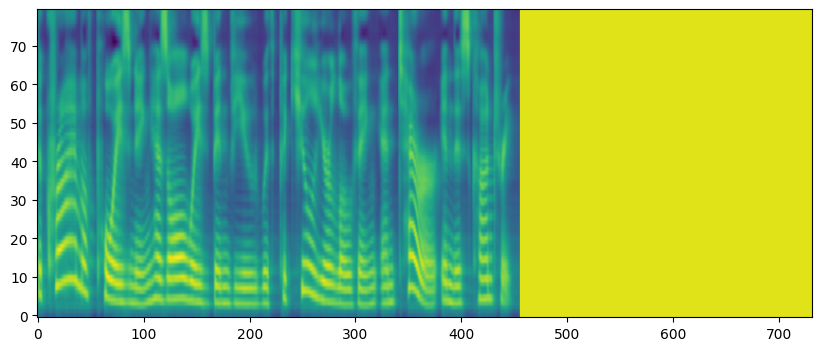

In [136]:
%matplotlib inline
for mel_batch, audio_batch, transcripts, audio_length in tqdm(dataloader):
    print("Mel shape:", mel_batch[0].shape)
    print("Audio shape:", audio_batch.shape)
    print("Text:", transcripts[:2])
    print("Lengths:", audio_length)
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_batch[0], aspect='auto', origin='lower')
    break

Простейшие нейросети для генератора и дискриминатора. Генератор при этом с апсемплингом, чтобы компенсировать разницу в длине спектрограммы и аудио.

In [137]:
class Generator(nn.Module):
    def __init__(self, upsample_factors=(8, 8, 4), n_mels=80):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(n_mels, 512, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.ConvTranspose1d(
                512,
                256,
                kernel_size=upsample_factors[0] * 2,
                stride=upsample_factors[0],
                padding=upsample_factors[0] // 2,
                output_padding=1,
            ),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(
                256,
                128,
                kernel_size=upsample_factors[1] * 2,
                stride=upsample_factors[1],
                padding=upsample_factors[1] // 2,
                output_padding=1,
            ),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(
                128,
                64,
                kernel_size=upsample_factors[2] * 2,
                stride=upsample_factors[2],
                padding=upsample_factors[2] // 2,
                output_padding=1,
            ),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 1, kernel_size=7, padding=3),
            nn.Tanh(),
        )

    def forward(self, mel):
        return self.model(mel)

In [142]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 64, 15, stride=1, padding=7),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, 15, stride=4, padding=7),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 256, kernel_size=15, stride=4, padding=7),
            nn.LeakyReLU(0.2),
            nn.Conv1d(256, 512, kernel_size=15, stride=4, padding=7),
            nn.LeakyReLU(0.2),
            nn.Conv1d(512, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, audio):
        out = self.model(audio)
        return out.mean(dim=[1, 2])

Для выравнивания данных в батче, добавим маски.

В качестве лоссов для генератора используем комбинацию l1 и состязательного лосса, с преимуществом в сторону l1, чтобы модель быстрее училась восстанавливать форму сигнала, а во вторую очередь обманывать дискриминатор.

Для дискриминатора используем обычные MSE лоссы.

In [139]:
def get_mask_from_lengths(lengths, max_len=None):
    lengths = lengths.long()
    batch_size = lengths.size(0)
    max_len = max_len or lengths.max().item()
    ids = (
        torch.arange(0, max_len, device=lengths.device)
        .unsqueeze(0)
        .expand(batch_size, -1)
    )
    mask = ids < lengths.unsqueeze(1)
    return mask


def masked_l1_loss(input, target, mask):
    diff = torch.abs(input - target)
    diff = diff * mask.unsqueeze(1)
    return diff.sum() / mask.sum()


def generator_loss(
    d_fake, gen_audio, real_audio, lengths, l1_weight=45.0, adv_weight=1.0
):
    min_len = min(gen_audio.shape[2], real_audio.shape[2])
    gen_audio = gen_audio[:, :, :min_len]
    real_audio = real_audio[:, :, :min_len]
    lengths = torch.clamp(lengths, max=min_len)

    mask = get_mask_from_lengths(lengths, max_len=min_len).unsqueeze(1).float()
    l1 = masked_l1_loss(gen_audio, real_audio, mask) * l1_weight
    adv = F.mse_loss(d_fake, torch.ones_like(d_fake)) * adv_weight
    return l1 + adv


def discriminator_loss(d_real, d_fake):
    real_loss = F.mse_loss(d_real, torch.ones_like(d_real))
    fake_loss = F.mse_loss(d_fake, torch.zeros_like(d_fake))
    return real_loss + fake_loss

In [143]:
num_epochs = 100
d_steps = 5

generator = Generator()
generator.to(device)

discriminator = Discriminator()
discriminator.to(device)

g_opt = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.9))
d_opt = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.9))

scaler = torch.amp.GradScaler()

In [145]:
for epoch in range(num_epochs):
    for step, (mel, real_audio, _, lengths) in enumerate(tqdm(dataloader)):
        mel = mel.to(device, non_blocking=True)
        real_audio = real_audio.unsqueeze(1).to(device, non_blocking=True)
        lengths = torch.tensor(lengths).to(device, non_blocking=True)
        with torch.amp.autocast(device_type="cuda"):
            gen_audio = generator(mel)
            d_fake = discriminator(gen_audio)
            g_loss = generator_loss(d_fake, gen_audio, real_audio, lengths)

        g_opt.zero_grad()
        scaler.scale(g_loss).backward()
        scaler.step(g_opt)
        scaler.update()

        if step % d_steps == 0:
            with torch.amp.autocast(device_type="cuda"):
                d_real = discriminator(real_audio)
                d_fake_detach = discriminator(gen_audio.detach())
                d_loss = discriminator_loss(d_real, d_fake_detach)

            d_opt.zero_grad()
            scaler.scale(d_loss).backward()
            scaler.step(d_opt)
            scaler.update()
        else:
            d_loss = None

        if step % 100 == 0:
            if d_loss is not None:
                print(
                    f"Epoch {epoch} | Step {step} | G_loss: {g_loss.item():.4f} | D_loss: {d_loss.item():.4f}"
                )
            else:
                print(
                    f"Epoch {epoch} | Step {step} | G_loss: {g_loss.item():.4f} | D_loss: skipped"
                )

            print(
                f"Gen audio length: {gen_audio.size(2)}, Real audio length: {real_audio.size(2)}"
            )
            audio_to_save = gen_audio[0].detach().cpu().to(torch.float32)
            torchaudio.save("sample_gen.wav", audio_to_save, sample_rate=22050)

  0%|          | 1/819 [00:00<11:17,  1.21it/s]

Epoch 0 | Step 0 | G_loss: 45.3950 | D_loss: 0.9837
Gen audio length: 211237, Real audio length: 222109


  5%|▍         | 39/819 [00:11<03:55,  3.31it/s]


KeyboardInterrupt: 

По результатам экспериментов с лоссами, гиперпараметрами, методами получения мелбанков после 100 эпох обучения на выходе генерируется писк, а лоссы почти не меняются. 

Попробуем позаимствовать модели и цикл обучения в репозитории ориигинального [MelGAN](https://github.com/descriptinc/melgan-neurips/blob/master/mel2wav/modules.py#L88)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def WNConv1d(*args, **kwargs):
    return weight_norm(nn.Conv1d(*args, **kwargs))


def WNConvTranspose1d(*args, **kwargs):
    return weight_norm(nn.ConvTranspose1d(*args, **kwargs))


class Audio2Mel(nn.Module):
    def __init__(
        self,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        sampling_rate=22050,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=None,
    ):
        super().__init__()

        window = torch.hann_window(win_length).float()
        mel_basis = librosa_mel_fn(
            sampling_rate, n_fft, n_mel_channels, mel_fmin, mel_fmax
        )
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer("mel_basis", mel_basis)
        self.register_buffer("window", window)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.sampling_rate = sampling_rate
        self.n_mel_channels = n_mel_channels

    def forward(self, audio):
        p = (self.n_fft - self.hop_length) // 2
        audio = F.pad(audio, (p, p), "reflect").squeeze(1)
        fft = torch.stft(
            audio,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=False,
        )
        real_part, imag_part = fft.unbind(-1)
        magnitude = torch.sqrt(real_part ** 2 + imag_part ** 2)
        mel_output = torch.matmul(self.mel_basis, magnitude)
        log_mel_spec = torch.log10(torch.clamp(mel_output, min=1e-5))
        return log_mel_spec


class ResnetBlock(nn.Module):
    def __init__(self, dim, dilation=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.ReflectionPad1d(dilation),
            WNConv1d(dim, dim, kernel_size=3, dilation=dilation),
            nn.LeakyReLU(0.2),
            WNConv1d(dim, dim, kernel_size=1),
        )
        self.shortcut = WNConv1d(dim, dim, kernel_size=1)

    def forward(self, x):
        return self.shortcut(x) + self.block(x)


class Generator(nn.Module):
    def __init__(self, input_size, ngf, n_residual_layers):
        super().__init__()
        ratios = [8, 8, 2, 2]
        self.hop_length = np.prod(ratios)
        mult = int(2 ** len(ratios))

        model = [
            nn.ReflectionPad1d(3),
            WNConv1d(input_size, mult * ngf, kernel_size=7, padding=0),
        ]

        for i, r in enumerate(ratios):
            model += [
                nn.LeakyReLU(0.2),
                WNConvTranspose1d(
                    mult * ngf,
                    mult * ngf // 2,
                    kernel_size=r * 2,
                    stride=r,
                    padding=r // 2 + r % 2,
                    output_padding=r % 2,
                ),
            ]

            for j in range(n_residual_layers):
                model += [ResnetBlock(mult * ngf // 2, dilation=3 ** j)]

            mult //= 2

        model += [
            nn.LeakyReLU(0.2),
            nn.ReflectionPad1d(3),
            WNConv1d(ngf, 1, kernel_size=7, padding=0),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)
        self.apply(weights_init)

    def forward(self, x):
        return self.model(x)


class NLayerDiscriminator(nn.Module):
    def __init__(self, ndf, n_layers, downsampling_factor):
        super().__init__()
        model = nn.ModuleDict()

        model["layer_0"] = nn.Sequential(
            nn.ReflectionPad1d(7),
            WNConv1d(1, ndf, kernel_size=15),
            nn.LeakyReLU(0.2, True),
        )

        nf = ndf
        stride = downsampling_factor
        for n in range(1, n_layers + 1):
            nf_prev = nf
            nf = min(nf * stride, 1024)

            model["layer_%d" % n] = nn.Sequential(
                WNConv1d(
                    nf_prev,
                    nf,
                    kernel_size=stride * 10 + 1,
                    stride=stride,
                    padding=stride * 5,
                    groups=nf_prev // 4,
                ),
                nn.LeakyReLU(0.2, True),
            )

        nf = min(nf * 2, 1024)
        model["layer_%d" % (n_layers + 1)] = nn.Sequential(
            WNConv1d(nf_prev, nf, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.2, True),
        )

        model["layer_%d" % (n_layers + 2)] = WNConv1d(
            nf, 1, kernel_size=3, stride=1, padding=1
        )

        self.model = model

    def forward(self, x):
        results = []
        for key, layer in self.model.items():
            x = layer(x)
            results.append(x)
        return results


class Discriminator(nn.Module):
    def __init__(self, num_D, ndf, n_layers, downsampling_factor):
        super().__init__()
        self.model = nn.ModuleDict()
        for i in range(num_D):
            self.model[f"disc_{i}"] = NLayerDiscriminator(
                ndf, n_layers, downsampling_factor
            )

        self.downsample = nn.AvgPool1d(4, stride=2, padding=1, count_include_pad=False)
        self.apply(weights_init)

    def forward(self, x):
        results = []
        for key, disc in self.model.items():
            results.append(disc(x))
            x = self.downsample(x)
        return results

In [12]:
num_epochs = 100
d_steps = 5

generator = Generator(80,32,2)
generator.to(device)

discriminator = Discriminator(1,16,4,4)
discriminator.to(device)

g_opt = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.9))
d_opt = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.9))

scaler = torch.amp.GradScaler()

c:\_Experiments\GenSpeech_2025\venv\lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [13]:
for epoch in range(num_epochs):
    for step, (mel, real_audio, _, lengths) in enumerate(tqdm(dataloader)):
        mel = mel.to(device)
        real_audio = real_audio.unsqueeze(1).to(device)

        with torch.amp.autocast(device_type="cuda"):
            gen_audio = generator(mel)

            gen_audio_detach = gen_audio.detach()
            d_real_feats = discriminator(real_audio)
            d_fake_feats = discriminator(gen_audio_detach)
            d_loss = 0
            for scale in d_fake_feats:
                d_loss += F.relu(1 + scale[-1]).mean()

            for scale in d_real_feats:
                d_loss += F.relu(1 - scale[-1]).mean()
        d_opt.zero_grad()
        scaler.scale(d_loss).backward()
        scaler.step(d_opt)
        scaler.update()

        with torch.amp.autocast(device_type="cuda"):
            d_fake_feats = discriminator(gen_audio)
            g_loss = 0
            for scale in d_fake_feats:
                g_loss += -scale[-1].mean()

        g_opt.zero_grad()
        scaler.scale(g_loss).backward()
        scaler.step(g_opt)
        scaler.update()

        if step % 100 == 0:
            if d_loss is not None:
                print(
                    f"Epoch {epoch} | Step {step} | G_loss: {g_loss.item():.4f} | D_loss: {d_loss.item():.4f}"
                )
            else:
                print(
                    f"Epoch {epoch} | Step {step} | G_loss: {g_loss.item():.4f} | D_loss: skipped"
                )

            print(
                f"Gen audio length: {gen_audio.size(2)}, Real audio length: {real_audio.size(2)}"
            )
            audio_to_save = gen_audio[0].detach().cpu().to(torch.float32)
            torchaudio.save("sample_gen.wav", audio_to_save, sample_rate=22050)

  0%|          | 1/819 [00:01<26:08,  1.92s/it]

Epoch 0 | Step 0 | G_loss: -0.0096 | D_loss: 2.0000
Gen audio length: 182528, Real audio length: 201885


 12%|█▏        | 101/819 [02:37<18:48,  1.57s/it]

Epoch 0 | Step 100 | G_loss: -0.0966 | D_loss: 2.6367
Gen audio length: 200448, Real audio length: 216989


 25%|██▍       | 201/819 [05:10<15:51,  1.54s/it]

Epoch 0 | Step 200 | G_loss: -0.5400 | D_loss: 2.0000
Gen audio length: 206336, Real audio length: 216733


 37%|███▋      | 301/819 [07:49<13:52,  1.61s/it]

Epoch 0 | Step 300 | G_loss: -0.1063 | D_loss: 2.0293
Gen audio length: 206080, Real audio length: 218525


 49%|████▉     | 401/819 [10:32<11:37,  1.67s/it]

Epoch 0 | Step 400 | G_loss: -0.1005 | D_loss: 2.0000
Gen audio length: 217344, Real audio length: 222621


 61%|██████    | 501/819 [13:18<08:48,  1.66s/it]

Epoch 0 | Step 500 | G_loss: -0.1736 | D_loss: 1.9844
Gen audio length: 200960, Real audio length: 215197


 73%|███████▎  | 601/819 [15:59<05:31,  1.52s/it]

Epoch 0 | Step 600 | G_loss: -0.3586 | D_loss: 2.0781
Gen audio length: 196352, Real audio length: 219293


 86%|████████▌ | 701/819 [18:32<03:07,  1.59s/it]

Epoch 0 | Step 700 | G_loss: -0.2979 | D_loss: 2.0957
Gen audio length: 200448, Real audio length: 219037


 98%|█████████▊| 801/819 [21:03<00:25,  1.42s/it]

Epoch 0 | Step 800 | G_loss: -0.2556 | D_loss: 2.3516
Gen audio length: 178944, Real audio length: 209053


  0%|          | 1/819 [00:01<18:45,  1.38s/it]

Epoch 1 | Step 0 | G_loss: 0.0969 | D_loss: 2.5371
Gen audio length: 185600, Real audio length: 207005


 12%|█▏        | 101/819 [02:26<17:28,  1.46s/it]

Epoch 1 | Step 100 | G_loss: 1.0010 | D_loss: 1.6494
Gen audio length: 211712, Real audio length: 216221


 25%|██▍       | 201/819 [05:04<18:04,  1.75s/it]

Epoch 1 | Step 200 | G_loss: 0.5884 | D_loss: 2.0723
Gen audio length: 185600, Real audio length: 198557


 37%|███▋      | 301/819 [07:59<14:45,  1.71s/it]

Epoch 1 | Step 300 | G_loss: -0.3706 | D_loss: 1.7803
Gen audio length: 193792, Real audio length: 209309


 49%|████▉     | 401/819 [10:53<12:25,  1.78s/it]

Epoch 1 | Step 400 | G_loss: 0.9600 | D_loss: 1.4678
Gen audio length: 193280, Real audio length: 220829


 61%|██████    | 501/819 [13:47<09:05,  1.71s/it]

Epoch 1 | Step 500 | G_loss: 0.1646 | D_loss: 1.5723
Gen audio length: 183040, Real audio length: 222365


 73%|███████▎  | 601/819 [16:40<06:09,  1.70s/it]

Epoch 1 | Step 600 | G_loss: 1.1982 | D_loss: 2.1523
Gen audio length: 196096, Real audio length: 221085


 86%|████████▌ | 701/819 [19:36<03:29,  1.78s/it]

Epoch 1 | Step 700 | G_loss: 0.8135 | D_loss: 0.8613
Gen audio length: 216576, Real audio length: 220317


 98%|█████████▊| 801/819 [22:30<00:31,  1.75s/it]

Epoch 1 | Step 800 | G_loss: 0.2496 | D_loss: 2.3027
Gen audio length: 197632, Real audio length: 210333


  0%|          | 1/819 [00:01<19:22,  1.42s/it]

Epoch 2 | Step 0 | G_loss: 0.2524 | D_loss: 1.9082
Gen audio length: 181248, Real audio length: 212125


 12%|█▏        | 101/819 [02:33<18:27,  1.54s/it]

Epoch 2 | Step 100 | G_loss: 1.3584 | D_loss: 1.7383
Gen audio length: 200704, Real audio length: 217245


 25%|██▍       | 201/819 [05:04<15:57,  1.55s/it]

Epoch 2 | Step 200 | G_loss: 0.6772 | D_loss: 1.7227
Gen audio length: 199168, Real audio length: 211357


 37%|███▋      | 301/819 [07:35<12:50,  1.49s/it]

Epoch 2 | Step 300 | G_loss: 0.4961 | D_loss: 1.9531
Gen audio length: 194304, Real audio length: 213149


 49%|████▉     | 401/819 [10:05<10:57,  1.57s/it]

Epoch 2 | Step 400 | G_loss: -0.3318 | D_loss: 1.9551
Gen audio length: 205056, Real audio length: 220829


 61%|██████    | 501/819 [12:37<08:00,  1.51s/it]

Epoch 2 | Step 500 | G_loss: 0.5786 | D_loss: 2.0566
Gen audio length: 205824, Real audio length: 216477


 73%|███████▎  | 601/819 [15:09<05:25,  1.50s/it]

Epoch 2 | Step 600 | G_loss: 0.4897 | D_loss: 1.7383
Gen audio length: 187904, Real audio length: 211613


 86%|████████▌ | 701/819 [17:42<02:54,  1.48s/it]

Epoch 2 | Step 700 | G_loss: 0.0460 | D_loss: 2.2383
Gen audio length: 181248, Real audio length: 215453


 98%|█████████▊| 801/819 [20:12<00:27,  1.51s/it]

Epoch 2 | Step 800 | G_loss: 0.6772 | D_loss: 1.9121
Gen audio length: 198144, Real audio length: 219549


  0%|          | 1/819 [00:01<19:40,  1.44s/it]

Epoch 3 | Step 0 | G_loss: 0.5830 | D_loss: 1.9746
Gen audio length: 196608, Real audio length: 205725


 12%|█▏        | 101/819 [02:26<17:20,  1.45s/it]

Epoch 3 | Step 100 | G_loss: 0.5142 | D_loss: 1.5391
Gen audio length: 197120, Real audio length: 219037


 25%|██▍       | 201/819 [04:52<15:19,  1.49s/it]

Epoch 3 | Step 200 | G_loss: 0.8887 | D_loss: 2.0410
Gen audio length: 199680, Real audio length: 222109


 37%|███▋      | 301/819 [07:17<12:44,  1.48s/it]

Epoch 3 | Step 300 | G_loss: 0.6284 | D_loss: 2.0137
Gen audio length: 208384, Real audio length: 216221


 49%|████▉     | 401/819 [09:42<10:07,  1.45s/it]

Epoch 3 | Step 400 | G_loss: 0.4167 | D_loss: 1.8984
Gen audio length: 185600, Real audio length: 212125


 61%|██████    | 501/819 [12:07<07:49,  1.47s/it]

Epoch 3 | Step 500 | G_loss: 0.3630 | D_loss: 1.6973
Gen audio length: 198144, Real audio length: 220061


 73%|███████▎  | 601/819 [14:32<05:21,  1.47s/it]

Epoch 3 | Step 600 | G_loss: 0.5854 | D_loss: 1.5615
Gen audio length: 205568, Real audio length: 212637


 86%|████████▌ | 701/819 [16:58<02:51,  1.45s/it]

Epoch 3 | Step 700 | G_loss: 0.5469 | D_loss: 1.9688
Gen audio length: 200448, Real audio length: 219037


 98%|█████████▊| 801/819 [19:23<00:26,  1.44s/it]

Epoch 3 | Step 800 | G_loss: 0.4912 | D_loss: 1.8682
Gen audio length: 194560, Real audio length: 212125


  0%|          | 1/819 [00:01<20:09,  1.48s/it]

Epoch 4 | Step 0 | G_loss: 0.2084 | D_loss: 1.9707
Gen audio length: 200448, Real audio length: 214429


 12%|█▏        | 101/819 [02:25<17:00,  1.42s/it]

Epoch 4 | Step 100 | G_loss: 0.5669 | D_loss: 2.3047
Gen audio length: 203520, Real audio length: 219293


 25%|██▍       | 201/819 [04:49<15:21,  1.49s/it]

Epoch 4 | Step 200 | G_loss: 0.1517 | D_loss: 1.7861
Gen audio length: 198400, Real audio length: 215197


 37%|███▋      | 301/819 [07:14<12:07,  1.41s/it]

Epoch 4 | Step 300 | G_loss: 0.2803 | D_loss: 2.0664
Gen audio length: 176384, Real audio length: 190621


 49%|████▉     | 401/819 [09:40<09:55,  1.42s/it]

Epoch 4 | Step 400 | G_loss: 0.7065 | D_loss: 1.8320
Gen audio length: 189952, Real audio length: 212381


 61%|██████    | 501/819 [12:07<07:59,  1.51s/it]

Epoch 4 | Step 500 | G_loss: -0.0729 | D_loss: 2.0117
Gen audio length: 197120, Real audio length: 216733


 73%|███████▎  | 601/819 [14:35<05:22,  1.48s/it]

Epoch 4 | Step 600 | G_loss: 0.5996 | D_loss: 2.0273
Gen audio length: 191744, Real audio length: 212381


 86%|████████▌ | 701/819 [17:11<03:01,  1.54s/it]

Epoch 4 | Step 700 | G_loss: 0.1714 | D_loss: 1.9971
Gen audio length: 198656, Real audio length: 213917


 98%|█████████▊| 801/819 [19:47<00:27,  1.54s/it]

Epoch 4 | Step 800 | G_loss: 0.0515 | D_loss: 1.8516
Gen audio length: 187136, Real audio length: 203421


  0%|          | 1/819 [00:01<22:11,  1.63s/it]

Epoch 5 | Step 0 | G_loss: -0.0978 | D_loss: 1.9814
Gen audio length: 206336, Real audio length: 218013


 12%|█▏        | 101/819 [02:38<19:43,  1.65s/it]

Epoch 5 | Step 100 | G_loss: 0.1604 | D_loss: 1.9297
Gen audio length: 216576, Real audio length: 216989


 25%|██▍       | 201/819 [05:16<16:49,  1.63s/it]

Epoch 5 | Step 200 | G_loss: 0.6235 | D_loss: 1.4824
Gen audio length: 211968, Real audio length: 222109


 37%|███▋      | 301/819 [07:52<13:28,  1.56s/it]

Epoch 5 | Step 300 | G_loss: 0.5864 | D_loss: 1.4141
Gen audio length: 180992, Real audio length: 191389


 49%|████▉     | 401/819 [10:28<11:12,  1.61s/it]

Epoch 5 | Step 400 | G_loss: 0.7183 | D_loss: 1.8457
Gen audio length: 201216, Real audio length: 220573


 61%|██████    | 501/819 [13:04<08:10,  1.54s/it]

Epoch 5 | Step 500 | G_loss: 0.8638 | D_loss: 1.6426
Gen audio length: 176640, Real audio length: 197533


 73%|███████▎  | 601/819 [15:41<05:39,  1.56s/it]

Epoch 5 | Step 600 | G_loss: 0.4875 | D_loss: 1.2080
Gen audio length: 190208, Real audio length: 212637


 86%|████████▌ | 701/819 [18:17<02:51,  1.46s/it]

Epoch 5 | Step 700 | G_loss: 0.1930 | D_loss: 1.3145
Gen audio length: 176384, Real audio length: 222365


 98%|█████████▊| 801/819 [20:54<00:28,  1.59s/it]

Epoch 5 | Step 800 | G_loss: 1.7100 | D_loss: 1.1260
Gen audio length: 194304, Real audio length: 218525


  0%|          | 1/819 [00:01<21:52,  1.60s/it]

Epoch 6 | Step 0 | G_loss: 0.9736 | D_loss: 0.8921
Gen audio length: 194048, Real audio length: 219805


 12%|█▏        | 101/819 [02:37<18:59,  1.59s/it]

Epoch 6 | Step 100 | G_loss: 1.5986 | D_loss: 1.3203
Gen audio length: 205056, Real audio length: 222109


 25%|██▍       | 201/819 [05:13<16:03,  1.56s/it]

Epoch 6 | Step 200 | G_loss: 1.4600 | D_loss: 1.4697
Gen audio length: 177152, Real audio length: 207261


 37%|███▋      | 301/819 [07:49<13:21,  1.55s/it]

Epoch 6 | Step 300 | G_loss: 0.9263 | D_loss: 1.6914
Gen audio length: 198144, Real audio length: 222621


 49%|████▉     | 401/819 [10:26<11:14,  1.61s/it]

Epoch 6 | Step 400 | G_loss: 2.3574 | D_loss: 2.1973
Gen audio length: 197888, Real audio length: 215197


 61%|██████    | 501/819 [13:02<08:20,  1.57s/it]

Epoch 6 | Step 500 | G_loss: 0.4058 | D_loss: 1.5391
Gen audio length: 199168, Real audio length: 216221


 73%|███████▎  | 601/819 [15:38<05:29,  1.51s/it]

Epoch 6 | Step 600 | G_loss: 0.2487 | D_loss: 1.7744
Gen audio length: 182784, Real audio length: 212125


 86%|████████▌ | 701/819 [18:14<03:08,  1.59s/it]

Epoch 6 | Step 700 | G_loss: 1.3057 | D_loss: 0.8374
Gen audio length: 197632, Real audio length: 216733


 98%|█████████▊| 801/819 [20:49<00:29,  1.62s/it]

Epoch 6 | Step 800 | G_loss: 1.3809 | D_loss: 0.6338
Gen audio length: 210432, Real audio length: 220061


  0%|          | 1/819 [00:01<21:53,  1.61s/it]

Epoch 7 | Step 0 | G_loss: 0.7339 | D_loss: 1.5684
Gen audio length: 203520, Real audio length: 220317


 12%|█▏        | 101/819 [02:37<19:07,  1.60s/it]

Epoch 7 | Step 100 | G_loss: 0.9194 | D_loss: 1.2207
Gen audio length: 200192, Real audio length: 211869


 25%|██▍       | 201/819 [05:15<15:58,  1.55s/it]

Epoch 7 | Step 200 | G_loss: 1.2773 | D_loss: 1.3008
Gen audio length: 196096, Real audio length: 222621


 37%|███▋      | 301/819 [07:53<13:42,  1.59s/it]

Epoch 7 | Step 300 | G_loss: 1.4033 | D_loss: 0.2244
Gen audio length: 193792, Real audio length: 212637


 49%|████▉     | 401/819 [10:28<11:06,  1.60s/it]

Epoch 7 | Step 400 | G_loss: 1.4736 | D_loss: 0.8008
Gen audio length: 205824, Real audio length: 220573


 61%|██████    | 501/819 [13:04<08:11,  1.55s/it]

Epoch 7 | Step 500 | G_loss: 2.1953 | D_loss: 0.8760
Gen audio length: 187136, Real audio length: 210077


 73%|███████▎  | 601/819 [15:43<05:45,  1.58s/it]

Epoch 7 | Step 600 | G_loss: 0.9951 | D_loss: 1.7520
Gen audio length: 197120, Real audio length: 211357


 86%|████████▌ | 701/819 [18:21<03:03,  1.55s/it]

Epoch 7 | Step 700 | G_loss: 0.9814 | D_loss: 1.9453
Gen audio length: 175616, Real audio length: 199837


 98%|█████████▊| 801/819 [20:55<00:28,  1.58s/it]

Epoch 7 | Step 800 | G_loss: 0.4954 | D_loss: 1.8691
Gen audio length: 192768, Real audio length: 215197


  0%|          | 1/819 [00:01<21:55,  1.61s/it]

Epoch 8 | Step 0 | G_loss: 1.2119 | D_loss: 1.1982
Gen audio length: 194560, Real audio length: 222109


 12%|█▏        | 101/819 [02:38<18:19,  1.53s/it]

Epoch 8 | Step 100 | G_loss: 1.9316 | D_loss: 1.7715
Gen audio length: 193792, Real audio length: 215197


 25%|██▍       | 201/819 [05:16<16:44,  1.63s/it]

Epoch 8 | Step 200 | G_loss: 1.4023 | D_loss: 0.8735
Gen audio length: 209152, Real audio length: 216477


 37%|███▋      | 301/819 [07:54<13:28,  1.56s/it]

Epoch 8 | Step 300 | G_loss: 0.7910 | D_loss: 1.1602
Gen audio length: 203776, Real audio length: 222621


 49%|████▉     | 401/819 [10:30<11:04,  1.59s/it]

Epoch 8 | Step 400 | G_loss: 1.9570 | D_loss: 0.4473
Gen audio length: 202240, Real audio length: 219293


 61%|██████    | 501/819 [13:05<08:21,  1.58s/it]

Epoch 8 | Step 500 | G_loss: 1.0635 | D_loss: 0.5737
Gen audio length: 202752, Real audio length: 218013


 73%|███████▎  | 601/819 [15:42<05:50,  1.61s/it]

Epoch 8 | Step 600 | G_loss: 1.6611 | D_loss: 0.8672
Gen audio length: 201728, Real audio length: 216989


 86%|████████▌ | 701/819 [18:21<03:08,  1.60s/it]

Epoch 8 | Step 700 | G_loss: 2.6836 | D_loss: 1.6240
Gen audio length: 199680, Real audio length: 214429


 98%|█████████▊| 801/819 [20:57<00:28,  1.58s/it]

Epoch 8 | Step 800 | G_loss: 0.5850 | D_loss: 1.2129
Gen audio length: 200448, Real audio length: 220573


  0%|          | 1/819 [00:01<21:32,  1.58s/it]

Epoch 9 | Step 0 | G_loss: 1.1758 | D_loss: 0.5205
Gen audio length: 196096, Real audio length: 222621


 12%|█▏        | 101/819 [02:38<18:28,  1.54s/it]

Epoch 9 | Step 100 | G_loss: 2.2051 | D_loss: 0.3413
Gen audio length: 184576, Real audio length: 203933


 25%|██▍       | 201/819 [05:16<16:15,  1.58s/it]

Epoch 9 | Step 200 | G_loss: 1.5908 | D_loss: 1.6006
Gen audio length: 186112, Real audio length: 219037


 37%|███▋      | 301/819 [07:53<13:28,  1.56s/it]

Epoch 9 | Step 300 | G_loss: 1.3809 | D_loss: 1.0674
Gen audio length: 191744, Real audio length: 220829


 49%|████▉     | 401/819 [10:30<11:06,  1.59s/it]

Epoch 9 | Step 400 | G_loss: 1.5205 | D_loss: 1.1270
Gen audio length: 196096, Real audio length: 222109


 61%|██████    | 501/819 [13:08<08:28,  1.60s/it]

Epoch 9 | Step 500 | G_loss: 1.9209 | D_loss: 1.5459
Gen audio length: 197632, Real audio length: 212381


 73%|███████▎  | 601/819 [15:43<05:33,  1.53s/it]

Epoch 9 | Step 600 | G_loss: 1.8359 | D_loss: 1.4404
Gen audio length: 182016, Real audio length: 203165


 86%|████████▌ | 701/819 [18:20<03:10,  1.61s/it]

Epoch 9 | Step 700 | G_loss: 0.5308 | D_loss: 1.6133
Gen audio length: 199936, Real audio length: 214173


 98%|█████████▊| 801/819 [20:57<00:28,  1.58s/it]

Epoch 9 | Step 800 | G_loss: 1.3809 | D_loss: 1.1689
Gen audio length: 203008, Real audio length: 217245


  0%|          | 1/819 [00:01<21:55,  1.61s/it]

Epoch 10 | Step 0 | G_loss: 1.9170 | D_loss: 0.7764
Gen audio length: 200704, Real audio length: 218269


  9%|▉         | 72/819 [01:53<19:33,  1.57s/it]


KeyboardInterrupt: 

Сохраним результаты обучения

In [ ]:
final_checkpoint = {
    "generator": generator.state_dict(),
    "discriminator": discriminator.state_dict(),
    "g_opt": g_opt.state_dict(),
    "d_opt": d_opt.state_dict(),
    "epoch": num_epochs,
    "losses": {
        "g_loss": g_loss.item(),
        # 'd_loss': d_loss.item()
    },
}

torch.save(final_checkpoint, "final_model.pt")

И попробуем сгенерировать аудио из текста

In [121]:
t2s = TextToSpecConverter()

checkpoint = torch.load("final_model.pt")
generator.load_state_dict(checkpoint["generator"])
generator.eval()

with open("test_sentences.txt") as f:
    sentences = [line.strip() for line in f.readlines()]
print(sentences)
for i, sent in enumerate(sentences):
    vec = t2s.text2spec(sent)
    print(vec.shape)

    mel = torch.tensor(vec).unsqueeze(0).to(device)

    mel = mel.transpose(1, 2)
    with torch.no_grad():
        audio = generator(mel).cpu().squeeze().numpy()
    sf.write(f"gen_{i}.wav", audio, samplerate=22050)

 > tts_models/en/ljspeech/fast_pitch is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: fast_pitch
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Vocoder Model: hifigan
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resam

после 10 эпох аудио все еще отвратительно звучат, хотя в этот раз появилась хотя бы какая то динамика. возможно при более длительном обучении можно было бы получить результат получше